In [1]:
!conda install -y -c anaconda psycopg2 sqlalchemy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [63]:
!pip install  xgboost

    100% |████████████████████████████████| 481kB 2.6MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/44/75/71/94198575ab2a2946397287601c0632d196bc56a7ff4b985aba
Successfully built xgboost
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install ipython-sql

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline

PARTNER_ID="35"

In [4]:
#Extra functions helpers to make plots

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [5]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




In [6]:
# build the pandas dataframe with the bid information
query="select * from ml_prep.offer_load_eligibility_last_event_by_session_usd_with_offer_undersampled_prod_" + PARTNER_ID
original_df = pd.read_sql_query(query, con)
original_df.head()

event_id            event_time  \
0  e180e4e8-4c0d-4267-8aa3-2e4c108fb6f6  2018-02-18T04:33:43Z   
1  9b4841d7-a1f2-4f3d-95f1-ccda128b9c1c  2017-10-05T06:40:53Z   
2  7fb7f956-2704-4319-8bd6-099099fab7df  2018-01-04T04:55:36Z   
3  82e2557e-e739-40d9-90ff-85fb7f8c85fb  2017-11-13T09:08:01Z   
4  5f24d7ea-3f7f-4036-a3cf-b6858e2b6d15  2017-11-21T23:15:20Z   

                           request_id  partner_id origin destination  \
0  HDjW1n29d3MlNkXTlw4fHtYsffUAZ3y87d          35    SYD         MEL   
1  xr9X8ifU9eIfzZlJmSL25yqj2k2aqnScOJ          35    PER         SYD   
2  j5eRDB4cgrZGD16xJvJ7HuDw0QAErWpegn          35    MKY         BNE   
3  YAbti806wDPq0qT4I8tG0regT6G38b9wIN          35    PER         MEL   
4  WTILgnazu4926ipWRQUtxQNCxvsXZD3GKt          35    SYD         ADL   

   flight_number departure_date departure_time currency     ...      \
0            842     2018-02-24          13:00      AUD     ...       
1            570     2017-10-08          22:55      AUD     ...       
2            608     2018-02-08          11:00      AUD     ...       
3            676     2017-11-17          05:20      AUD     ...       
4            444     2017-11-23          20:15      AUD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5       95       439             mi       73H          252.0   
1           5      260      2039             mi       73H          467.0   
2           5       85       497             mi       73H          274.0   
3           5      215      1680             mi       332          532.0   
4           5      130       724             mi       73H          265.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0          110.0            198.0     113.0591   4190706.0  
1          303.0            386.0     358.3891   3721242.0  
2           75.0            177.0      74.6985   3685810.0  
3          206.0            353.0     209.4122   3546763.0  
4           84.0            164.0      87.2284   3881342.0  

[5 rows x 33 columns]

In [7]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 33 columns):
event_id                              282354 non-null object
event_time                            282354 non-null object
request_id                            282354 non-null object
partner_id                            282354 non-null int64
origin                                282354 non-null object
destination                           282354 non-null object
flight_number                         282354 non-null int64
departure_date                        282354 non-null object
departure_time                        282354 non-null object
currency                              282354 non-null object
pnr                                   282354 non-null object
language                              282354 non-null object
pax                                   282354 non-null int64
eligibility                           282354 non-null bool
point_of_sale                         28

In [8]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [9]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
282349  2017-09-18T02:56:58Z          35    BNE         NAN            175   
282350  2017-09-18T00:34:48Z          35    BNE         DPS             43   
282351  2017-09-13T08:31:32Z          35    SYD         ZQN            162   
282352  2017-11-10T06:28:38Z          35    CNS         SYD           1408   
282353  2018-03-13T05:23:57Z          35    WLG         BNE            100   

       departure_date departure_time currency language  pax   ...    \
282349     2017-09-25          09:25      AUD       en    2   ...     
282350     2017-09-21          10:05      AUD       en    4   ...     
282351     2017-11-07          10:30      AUD       en    2   ...     
282352     2017-11-27          05:10      USD       en    1   ...     
282353     2018-03-26          07:00      AUD       EN    1   ...     

             upgrade_type duration distance equipment slider_max_usd  \
282349  BUSINESS_DOMESTIC      210     1689       73H          358.0   
282350  BUSINESS_DOMESTIC      400     2791       73H          477.0   
282351  BUSINESS_DOMESTIC      180     1206       73H          478.0   
282352  BUSINESS_DOMESTIC      185     1227       73H          383.0   
282353  BUSINESS_DOMESTIC      240     1561       73H          314.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
282349          143.0            294.0      159.4214    3666008.0    True  
282350          230.0            395.0      278.9876    3665716.0    True  
282351          151.0            374.0      159.5947    3650926.0    True  
282352          110.0            215.0      175.0000    3842722.0    True  
282353          101.0            251.0      102.1794    3533559.0    True  

[5 rows x 26 columns]

In [10]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    282354.0  282354.000000  282354.000000  282354.000000  282354.000000   
mean         35.0     635.342620       1.599875     244.238541    1825.438921   
std           0.0     475.124699       0.867205     237.178111    2161.982361   
min          35.0       1.000000       1.000000      50.000000     147.000000   
25%          35.0     228.000000       1.000000      95.000000     465.000000   
50%          35.0     562.000000       1.000000     145.000000     867.000000   
75%          35.0     916.000000       2.000000     260.000000    1972.000000   
max          35.0    1898.000000       5.000000     950.000000    7936.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   282354.000000   282354.000000     282354.000000  56471.000000   
mean       580.985603      233.391849        452.464389    194.889439   
std        841.365366      372.216045        701.001238    216.869817   
min        138.000000       41.000000         75.000000     45.523100   
25%        243.000000       91.000000        176.000000     98.942900   
50%        308.000000      114.000000        224.000000    129.701600   
75%        456.000000      226.000000        362.000000    220.785600   
max       5520.000000     3111.000000       4798.000000   4235.000000   

        customer_id  
count  5.647100e+04  
mean   3.691840e+06  
std    5.943228e+05  
min    1.851429e+06  
25%    3.657488e+06  
50%    3.865622e+06  
75%    4.082716e+06  
max    4.315807e+06

In [11]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 282354  282354      282354         282354   
unique                213539      44          44            510   
top     2018-01-04T03:49:05Z     MEL         MEL     2017-12-22   
freq                       7   57985       57920           2238   

       departure_time currency language point_of_sale    channel_source  \
count          282354   282354   282354        282354            282354   
unique            227       14        3             3              6065   
top             11:15      AUD       en            GS  PRE_TRAVEL_EMAIL   
freq             5593   267691   159919        204485             74243   

       carrier_code fare_class from_cabin       upgrade_type equipment  
count        282354     282354     282354             282354    282354  
unique            1         16          2                  4         6  
top              VA          T    ECONOMY  BUSINESS_DOMESTIC       73H  
freq         282354      81324     279248             220629    214583

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 26 columns):
event_time          282354 non-null object
partner_id          282354 non-null int64
origin              282354 non-null object
destination         282354 non-null object
flight_number       282354 non-null int64
departure_date      282354 non-null object
departure_time      282354 non-null object
currency            282354 non-null object
language            282354 non-null object
pax                 282354 non-null int64
eligibility         282354 non-null bool
point_of_sale       282354 non-null object
channel_source      282354 non-null object
carrier_code        282354 non-null object
fare_class          282354 non-null object
from_cabin          282354 non-null object
upgrade_type        282354 non-null object
duration            282354 non-null int64
distance            282354 non-null int64
equipment           282354 non-null object
slider_max_usd      282354 non-null 

## Some visual analysis

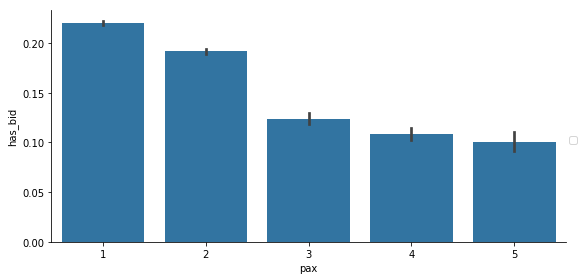

In [13]:
plot_categories( df , cat = 'pax' , target = 'has_bid' )

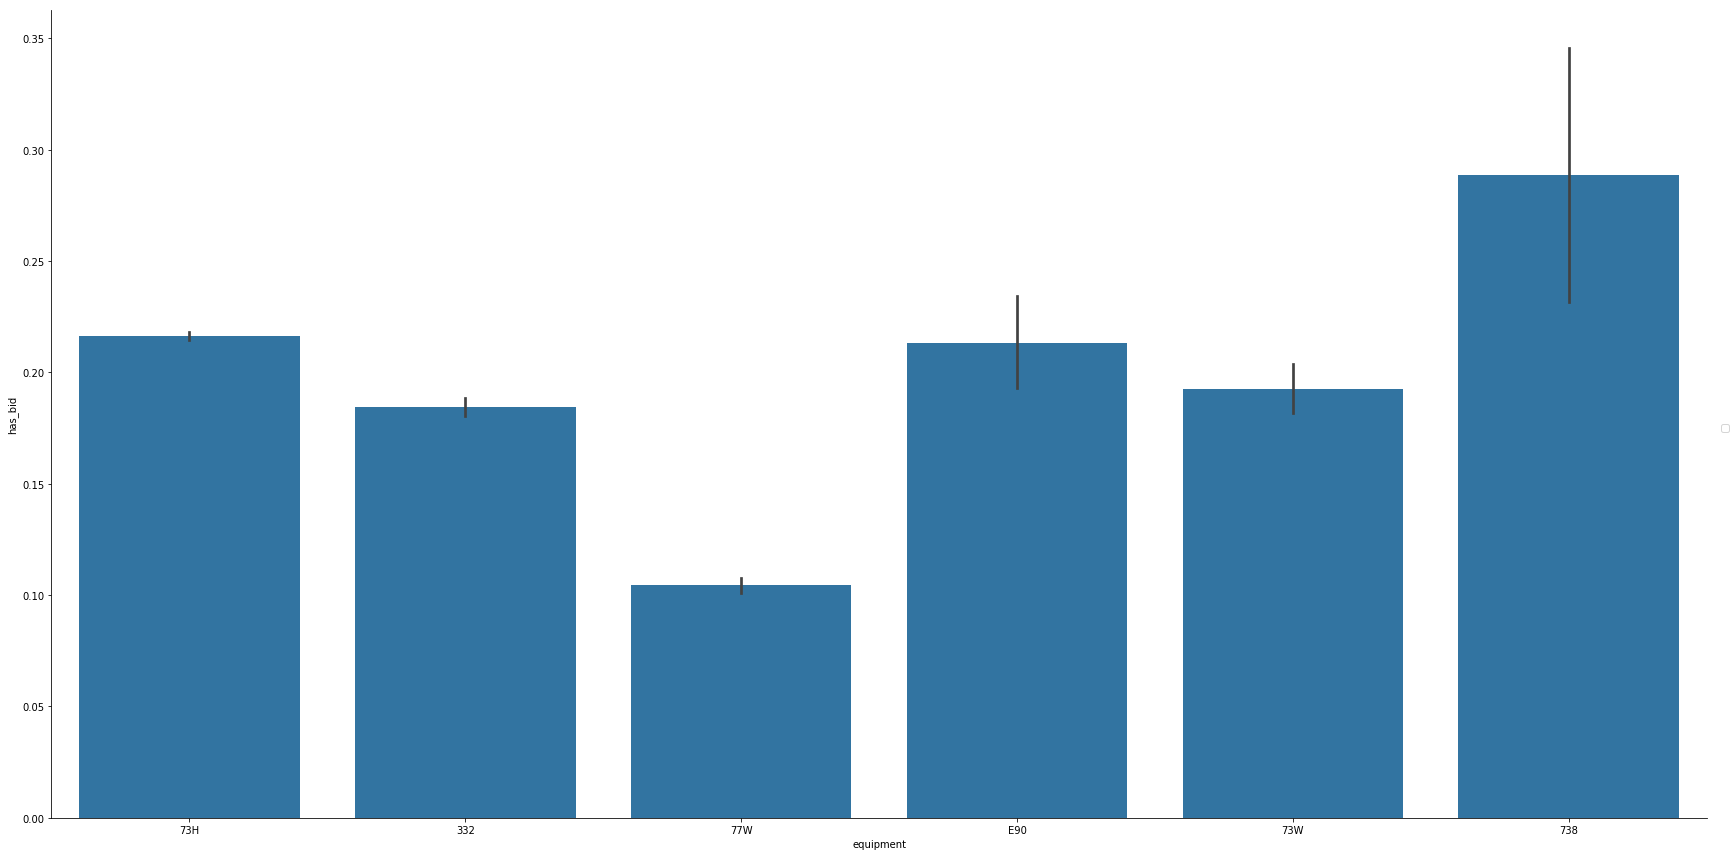

In [14]:
plot_categories( df , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

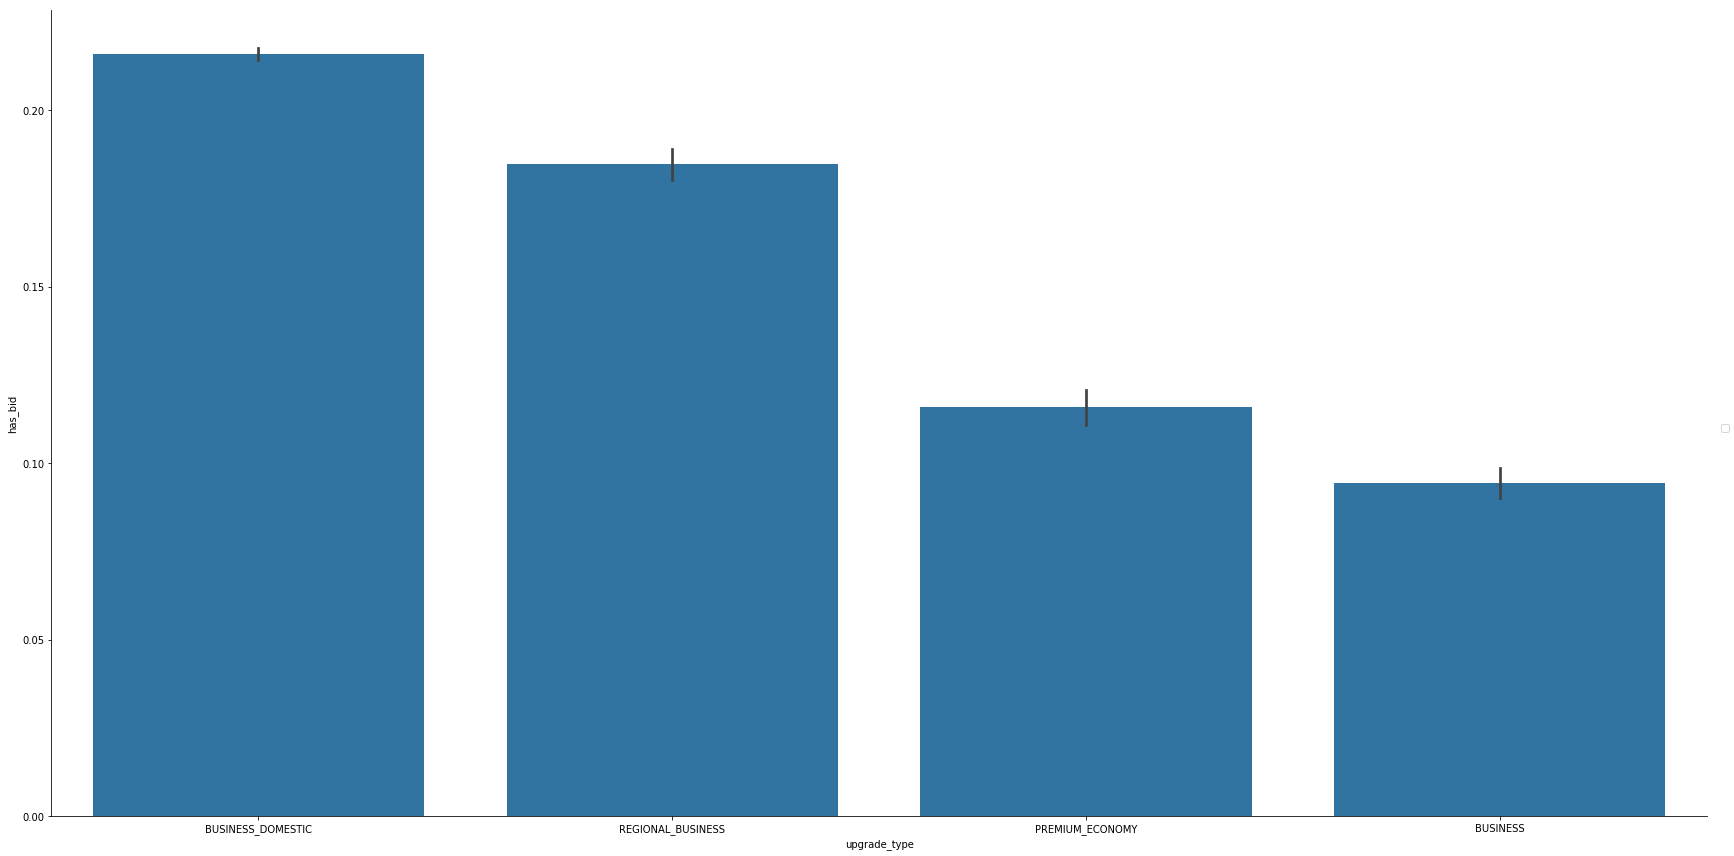

In [15]:
plot_categories( df , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

In [16]:
plot_categories( df , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

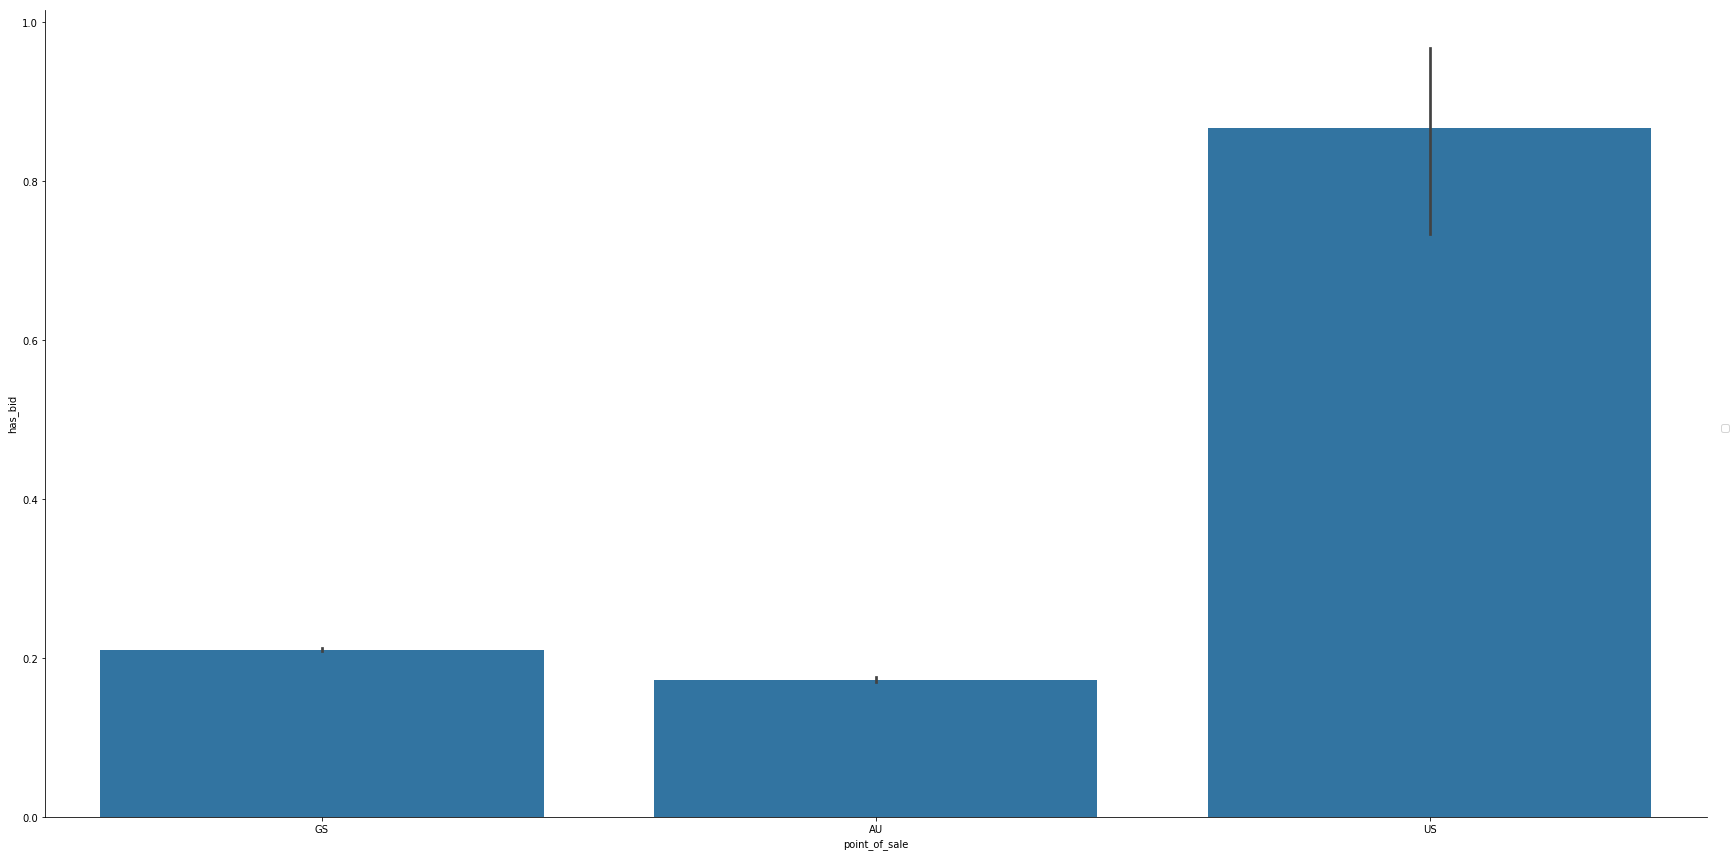

In [17]:
plot_categories( df , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

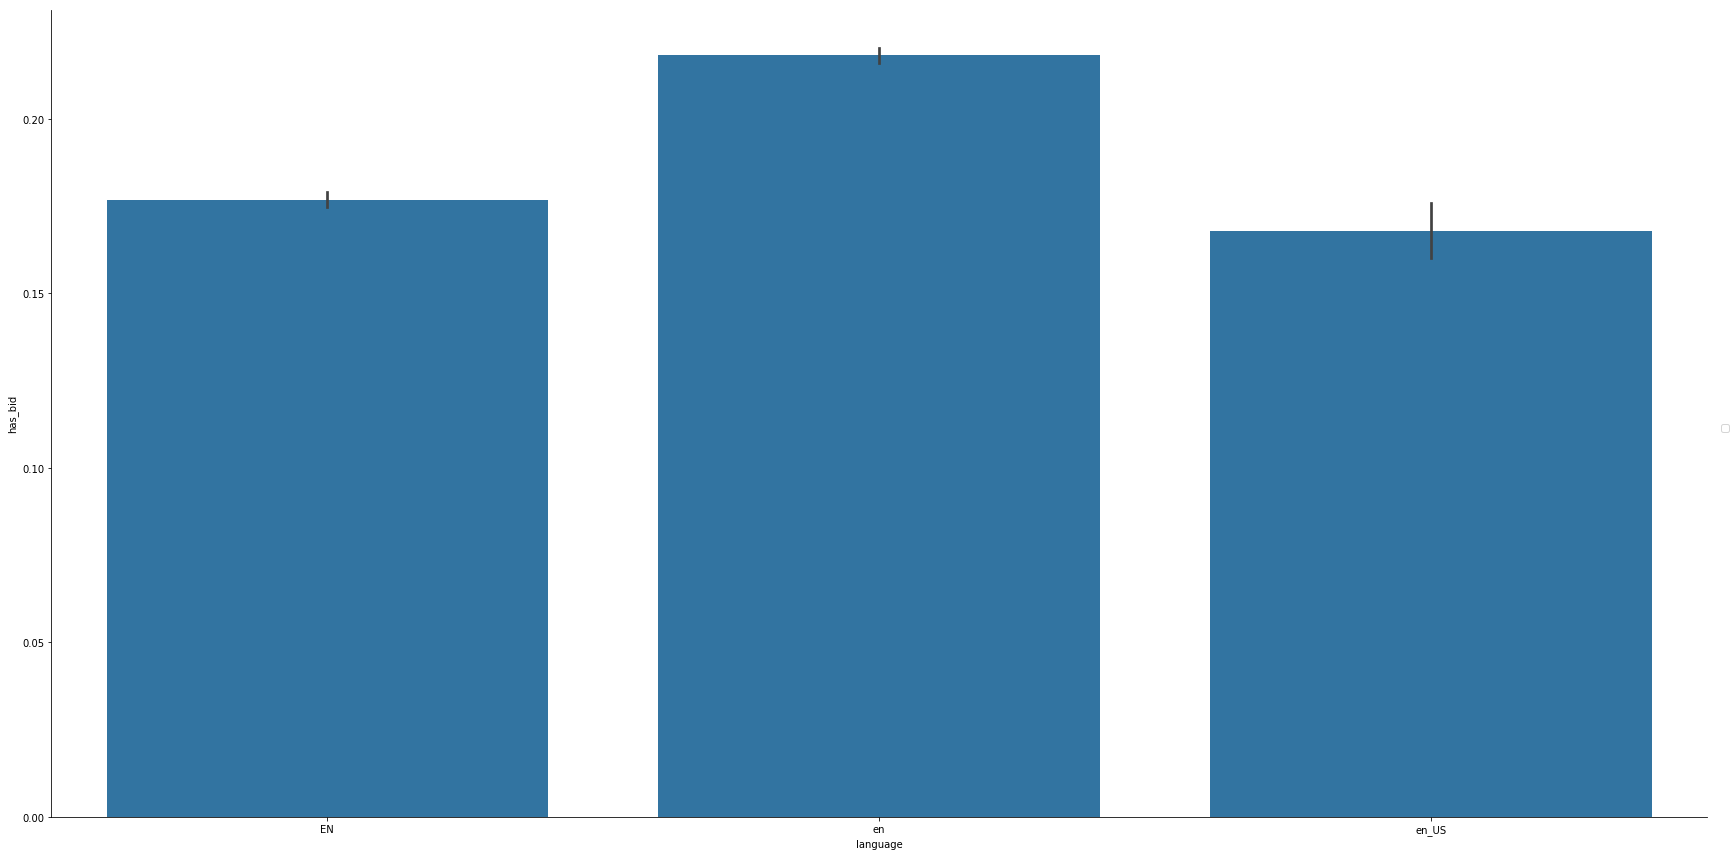

In [18]:
plot_categories( df , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

### Removing features fill nans

In [19]:
df_nonNas = df.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)

df_nonNas['pax'] = df_nonNas['pax'].fillna(1)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)


train_df = df_nonNas.drop(['customer_id', 'offer_amount', 'carrier_code', 'partner_id'],axis = 1).copy()


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 22 columns):
event_time          282354 non-null object
origin              282354 non-null object
destination         282354 non-null object
flight_number       282354 non-null float32
departure_date      282354 non-null object
departure_time      282354 non-null object
currency            282354 non-null object
language            282354 non-null object
pax                 282354 non-null float32
eligibility         282354 non-null bool
point_of_sale       282354 non-null object
channel_source      282354 non-null object
fare_class          282354 non-null object
from_cabin          282354 non-null object
upgrade_type        282354 non-null object
duration            282354 non-null float32
distance            282354 non-null float32
equipment           282354 non-null object
slider_max_usd      282354 non-null float32
slider_min_usd      282354 non-null float32
slider_start_usd    28235

## Add features

In [21]:
#add days before departure and destination_origin
train_df2 = train_df.copy()

train_df2["event_time"] = train_df2["event_time"].astype('datetime64[ns]')
train_df2["event_time"] = train_df2["event_time"].apply(lambda x: x.date() )
train_df2["departure_date"] = train_df2["departure_date"].astype('datetime64[ns]')
train_df2["departure_date"] = train_df2["departure_date"].apply(lambda x: x.date() )
train_df2["days_before_departure"] = train_df2["departure_date"] - train_df2["event_time"]
train_df2["days_before_departure"] = train_df2["days_before_departure"].apply(lambda x: x.days)
train_df2["destination_origin"] = train_df2["destination"]  + "-" + train_df2["origin"]

train_df2.drop(['event_time', 'departure_date', 'departure_time', 'eligibility'], axis=1, inplace=True)


In [22]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 20 columns):
origin                   282354 non-null object
destination              282354 non-null object
flight_number            282354 non-null float32
currency                 282354 non-null object
language                 282354 non-null object
pax                      282354 non-null float32
point_of_sale            282354 non-null object
channel_source           282354 non-null object
fare_class               282354 non-null object
from_cabin               282354 non-null object
upgrade_type             282354 non-null object
duration                 282354 non-null float32
distance                 282354 non-null float32
equipment                282354 non-null object
slider_max_usd           282354 non-null float32
slider_min_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departur

### Factorize categorical features

In [23]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [24]:
#factorize the categorical fields
columns_cat = ["origin", "destination", "flight_number", "currency", "language", "point_of_sale", "fare_class", "from_cabin", "upgrade_type", "equipment", "destination_origin"]  
train_df_fact = factorize_df(train_df2, columns_cat) 

In [25]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 20 columns):
origin                   282354 non-null int64
destination              282354 non-null int64
flight_number            282354 non-null int64
currency                 282354 non-null int64
language                 282354 non-null int64
pax                      282354 non-null float32
point_of_sale            282354 non-null int64
channel_source           282354 non-null int64
fare_class               282354 non-null int64
from_cabin               282354 non-null int64
upgrade_type             282354 non-null int64
duration                 282354 non-null float32
distance                 282354 non-null float32
equipment                282354 non-null int64
slider_max_usd           282354 non-null float32
slider_min_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departure    282354 

## Create a models and evaluations

In [64]:
#Function utils

random_forest = RandomForestClassifier(n_estimators=100)
from xgboost import XGBClassifier
boost = XGBClassifier()

def do_train(df_to_train, n_splits = 2, model = random_forest):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    accuracys = []
    aucs = []
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        #print( "\nFold ", i+1)
        model.fit(X_train, y_train)
        acc_random_forest = round(model.score(X_valid, y_valid) * 100, 2)
        accuracys.append(acc_random_forest)
        Y_test_pred = model.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        aucs.append(metrics.auc(fpr, tpr))
    print ("ACCURACY = {}".format(reduce(lambda x, y: x + y, accuracys) / len(accuracys)))  
    print ("AUC = {}".format(reduce(lambda x, y: x + y, aucs) / len(aucs)))  


In [27]:
do_train(train_df_fact)

ACCURACY = 78.635
AUC = 0.6536521571879963


### We already know the channel_source is a very important feature. Lets, try to figure out which of the features have more impact, training the model without them 

In [29]:
from itertools import combinations 
def combs(x):
    return [c for i in range(len(x)+1) for c in combinations(x,i)]

In [30]:
features = list(train_df_fact.drop(["has_bid", "channel_source"], axis = 1).columns.values)
featureCombinations = combs(features)
featureCombinations = list(map(lambda x: list(x), list(filter(lambda x: len(x) < 3 and len(x) > 0, featureCombinations))))

In [32]:
for featureSet in featureCombinations:
    print ("Feature removed {}".format(featureSet))
    do_train(train_df_fact.drop(featureSet,axis=1))

Feature removed ['origin']
ACCURACY = 78.675
AUC = 0.6566284743391828
Feature removed ['destination']
ACCURACY = 78.705
AUC = 0.6561216120442332
Feature removed ['flight_number']
ACCURACY = 78.115
AUC = 0.6479922502196394
Feature removed ['currency']
ACCURACY = 78.565
AUC = 0.6527514138635282
Feature removed ['language']
ACCURACY = 78.425
AUC = 0.6487550627100063
Feature removed ['pax']
ACCURACY = 78.1
AUC = 0.6433731644180514
Feature removed ['point_of_sale']
ACCURACY = 78.62
AUC = 0.6491851781753315
Feature removed ['fare_class']
ACCURACY = 78.255
AUC = 0.6507986955699894
Feature removed ['from_cabin']
ACCURACY = 78.63
AUC = 0.6542068011761252
Feature removed ['upgrade_type']
ACCURACY = 78.62
AUC = 0.6542875864681612
Feature removed ['duration']
ACCURACY = 78.66999999999999
AUC = 0.655729371106649
Feature removed ['distance']
ACCURACY = 78.655
AUC = 0.6541045706290087
Feature removed ['equipment']
ACCURACY = 78.555
AUC = 0.6532272821807839
Feature removed ['slider_max_usd']
ACCURACY 

ACCURACY = 78.14500000000001
AUC = 0.6392156211268027
Feature removed ['pax', 'fare_class']
ACCURACY = 77.73
AUC = 0.6408845043431171
Feature removed ['pax', 'from_cabin']
ACCURACY = 78.155
AUC = 0.6449517674480844
Feature removed ['pax', 'upgrade_type']
ACCURACY = 78.155
AUC = 0.6450350268280863
Feature removed ['pax', 'duration']
ACCURACY = 78.19999999999999
AUC = 0.645471835910141
Feature removed ['pax', 'distance']
ACCURACY = 78.13
AUC = 0.6447395981799157
Feature removed ['pax', 'equipment']
ACCURACY = 78.13
AUC = 0.6449833712241909
Feature removed ['pax', 'slider_max_usd']
ACCURACY = 78.03999999999999
AUC = 0.6435817811769483
Feature removed ['pax', 'slider_min_usd']
ACCURACY = 78.175
AUC = 0.6452326063342935
Feature removed ['pax', 'slider_start_usd']
ACCURACY = 78.06
AUC = 0.6444418069901463
Feature removed ['pax', 'days_before_departure']
ACCURACY = 76.33500000000001
AUC = 0.6261807469555911
Feature removed ['pax', 'destination_origin']
ACCURACY = 78.275
AUC = 0.64628943171192

Some conclusions about the previous results:

It seems that we could assume the following 3 features as keys here:

Feature removed ['days_before_departure']
ACCURACY = 77.16499999999999
AUC = 0.6355908548016409

Feature removed ['pax']
ACCURACY = 78.1
AUC = 0.643373164

eature removed ['flight_number']
ACCURACY = 78.115
AUC = 0.6479922502196394

And we could assume that we could remove "origin" "destination" "destination_origin"  "duration"

And we could assume that we could try to remove as well "from_cabin" "distance" "upgrade_type" "slider_min_usd" 
    

In [48]:
train_df_fact2 = train_df_fact.drop(['origin', 'destination', 'destination_origin', 'duration' ], axis = 1).copy()
do_train(train_df_fact2)



ACCURACY = 79.015
AUC = 0.6667883980459168


In [49]:
featuresToRemove = list(["from_cabin", "distance", "upgrade_type", "slider_min_usd"])
featureCombinations2 = combs(featuresToRemove)
featureCombinations2 = list(map(lambda x: list(x), list(filter(lambda x: len(x) > 1, featureCombinations2))))
for featureSet in featureCombinations2:
    print ("Features removed {}".format(featureSet))
    do_train(train_df_fact2.drop(featureSet,axis=1))

Features removed ['from_cabin', 'distance']
ACCURACY = 79.025
AUC = 0.6662265983032603
Features removed ['from_cabin', 'upgrade_type']
ACCURACY = 79.005
AUC = 0.6669507760101181
Features removed ['from_cabin', 'slider_min_usd']
ACCURACY = 79.055
AUC = 0.6676794784360609
Features removed ['distance', 'upgrade_type']
ACCURACY = 79.055
AUC = 0.6667220898035027
Features removed ['distance', 'slider_min_usd']
ACCURACY = 79.06
AUC = 0.6661899495971724
Features removed ['upgrade_type', 'slider_min_usd']
ACCURACY = 79.055
AUC = 0.6682581571921791
Features removed ['from_cabin', 'distance', 'upgrade_type']
ACCURACY = 79.00999999999999
AUC = 0.6668819775405879
Features removed ['from_cabin', 'distance', 'slider_min_usd']
ACCURACY = 79.025
AUC = 0.6662695809001249
Features removed ['from_cabin', 'upgrade_type', 'slider_min_usd']
ACCURACY = 79.09
AUC = 0.6683171953376515
Features removed ['distance', 'upgrade_type', 'slider_min_usd']
ACCURACY = 79.06
AUC = 0.6667233598213206
Features removed ['fro

In [51]:
#it seems that distance without the other 3 is nice to the model
train_df_fact3 = train_df_fact2.drop(['from_cabin', 'upgrade_type', 'slider_min_usd'], axis = 1).copy()
do_train(train_df_fact3)

ACCURACY = 79.06
AUC = 0.6686413361493604


In [54]:
train_df_fact3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282354 entries, 0 to 282353
Data columns (total 13 columns):
flight_number            282354 non-null int64
currency                 282354 non-null int64
language                 282354 non-null int64
pax                      282354 non-null float32
point_of_sale            282354 non-null int64
channel_source           282354 non-null int64
fare_class               282354 non-null int64
distance                 282354 non-null float32
equipment                282354 non-null int64
slider_max_usd           282354 non-null float32
slider_start_usd         282354 non-null float32
has_bid                  282354 non-null bool
days_before_departure    282354 non-null int64
dtypes: bool(1), float32(4), int64(8)
memory usage: 21.8 MB


#### Lets try to remove another features with more one round of removing combinations

In [58]:
features2 = list(train_df_fact3.drop(["has_bid", "flight_number", "channel_source", "days_before_departure", "pax"], axis = 1).columns.values)
featureCombinations2 = combs(features2)
featureCombinations2 = list(map(lambda x: list(x), list(filter(lambda x: len(x) < 2 and len(x) > 0, featureCombinations2))))


In [59]:
for featureSet in featureCombinations2:
    print ("Features removed {}".format(featureSet))
    do_train(train_df_fact.drop(featureSet,axis=1))


Features removed ['currency']
ACCURACY = 78.58000000000001
AUC = 0.6530516128490198
Features removed ['language']
ACCURACY = 78.42
AUC = 0.6485165564783368
Features removed ['point_of_sale']
ACCURACY = 78.59
AUC = 0.6482784333801421
Features removed ['fare_class']
ACCURACY = 78.245
AUC = 0.6509238142512899
Features removed ['distance']
ACCURACY = 78.65
AUC = 0.6547956266777457
Features removed ['equipment']
ACCURACY = 78.61
AUC = 0.6537863300882901
Features removed ['slider_max_usd']
ACCURACY = 78.50999999999999
AUC = 0.6530910027738173
Features removed ['slider_start_usd']
ACCURACY = 78.545
AUC = 0.6527818746414221


#### IT SEEMS THAT OUR DATASET REACHED THE OPTIMAL MINIMUM SET OF FEATURES

In [65]:
do_train(train_df_fact3)

ACCURACY = 79.03999999999999
AUC = 0.6676954489234638


In [68]:
do_train(train_df_fact3, model=boost)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ACCURACY = 80.78
AUC = 0.6976823490575625
